Data annotation is an essential prerequisite for developing and evaluating machine learning approaches to answer social science questions. Traditionally, agreement between annotators in choosing labels for data points has long been interpreted as a measure of reliability, based on the assumption that all annotators should behave in the same way (i.e., following the so-called prescriptive paradigm of data annotation). However, in case of more subjective tasks, different groups of annotators may exhibit differing annotation behaviors. This can be due to various reasons, such as differing levels of affectedness or experiences, and is increasingly being considered valuable information (i.e., following the so-called descriptive paradigm of data annotation).

The focus of this tutorial is therefore on *how we can measure and interpret group-specific annotation behavior, where annotators are assumed to label data similarly within the same group, but to differ more across groups*.

**Please be aware that this tutorial contains examples of hate speech.**

## Learning objectives

By the end of this tutorial, you will be able to:

- Understand the basics of inter-annotator agreement measures.
- Tell the differences of prescriptive and descriptive annotation data as well as aggregated and non-aggregated annotation.
- Calculate inter-annotator agreement for both data annotation paradigms.
- Interpret the outcomes in context of the different annotation paradigms.

## Target audience

This tutorial is targeted at:

- Researchers in the social sciences interested in inter-annotator agreement measures (also known as inter-rater reliability) and their application to cases involving coexisting perspectives on social constructs.
- NLP practitioners that are interested in capturing human label variation.
- Students or professionals beginning their journey in NLP and text analysis.
- Anyone interested in subjective annotation tasks.

## Duration

60-120 mins

## Use cases

- Assessing the reliability of annotations within homogeneous groups in data annotation of social constructs, such as hate speech, polarization, or misinformation.
- Measuring and comparing label variation for different sets of annotators (e.g., different demographic groups) in data annotation of social constructs, such as hate speech, polarization, or misinformation.
- Supporting hypotheses regarding how different groups perceive social constructs.
- Demonstrating the importance of a well-considered selection of annotator for training useful machine learning models (see Section 5.2 in Romberg et al., 2025).

## Setting up the computational environment

To run all the code in this tutorial, you need to install several packages:

In [1]:
#!pip install -r requirements.txt

We import each of these packages as follows:

In [2]:
import pandas as pd
import numpy as np
import krippendorff
from scipy.stats import wasserstein_distance
import matplotlib.pyplot as plt

pd.set_option('display.max_colwidth', None)  # show full cell content

## Basic concepts you should know for this tutorial

- **What is data annotation?** Enriching raw datasets with additional information tags is a common method of data analysis and builds the foundation for training and testing many machine learning algorithms. For example, to study hate speech in social media, posts (=raw data) are manually reviewed for whether they contain hate speech (=additional information tags). These tags are called annotations, labels, or codes (interchangeably).

- **Two paradigms of data annotation ("objective" vs. "subjective")**
Dataset annotation can be conducted with two different paradigms in mind (Röttger et al., 2022):
    - **Prescriptive annotation** is the longstanding and more common paradigm of data annotation. The goal is to achieve a consistent annotation across the dataset, e.g., through meticulous decision rules predefined in codebooks. The general credo is that there is always *exactly one correct assessment*; for example, in hate speech, each statement can be clearly categorized as such or not containing hate speech. The phenomenon is therefore assumed to be capturable in an objective manner.
    - **Descriptive annotation** has gained attention more recently, as it has become more and more obvious that subjective phenomena may more accurately be reflected by capturing a multitude of annotators' perspectives. The reason behind is that certain properties of an individual can shape the perception of a phenomenon. For instance, consider a white man and a black woman---it seems reasonable to expect that there may be cases of hate speech that these individuals assess differently. According to the paradigm, there can be *multiple valid assessments*, which are kept as additional source of information for real-world modeling.

    With our goal of comparing group-specific annotation behaviour, we follow the descriptive annotation paradigm in this tutorial.

- **Ground truth formats**
Related to the two paradigms of annotation, the "end product" of a data annotation pipeline looks different.
    - **Aggregated ground truth:** In prescriptive annotation, the annotations from multiple annotators are consolidated to create a single ground truth---typically by using methods such as majority voting or averaging the assigned scores. We refer to this as the *aggregated* ground truth.
    - **Non-Aggregated ground truth:** In descriptive annotation, the labels provided by multiple annotators may all be considered valid and are therefore not merged. Instead, each data point is associated with multiple labels. We refer to this as the *non-aggregated* ground truth.

- **What this tutorial means by annotator groups**
A set of individuals who share similar traits (such as demographics, experiences, values, or beliefs) and are thus expected to annotate more similarly to one another than to those with different traits, under the descriptive annotation paradigm.

- **Inter-annotator agreement measures** To assess how uniformly or diversely annotators work, *inter-annotator agreement measures* are typically used. These measures provide a score indicating how likely it is that multiple annotators make the same annotation decision on the same data items.

    *Note: While inter-annotator agreement measures inform us about the degree of agreement between annotators, they are commonly used as a proxy for reliability in prescriptive annotations: the more the annotators agree, the more consistent the annotation.*

    For a general overview of inter-annotator agreement measures and mathematical details, see: Artstein & Poesio (2008). We will use two selected measures in this tutorial (*in other use cases than provided in this tutorial, a different choice of measure might be more suitable*):

    - **Krippendorff's Alpha** is one of the most well-known inter-annotator agreement measure. It can handle sparse annotations and varying amounts of annotators per item (i.e., cases in which not all annotators worked on every data item; as the tutorial progresses and we look at datasets, the reason for this requirement will become clear).

        Conceptually, Krippendorff's Alpha integrates the observed disagreement between annotators with the amount of disagreement that is expected to happen by chance, thus providing a chance-corrected agreement coefficient in the range from -1 to 1. A value of 1 indicates *perfect agreement between annotators*, -1 *systematic disagreement*, and 0 *random agreement*.


    - **Wasserstein distance**, also known as Earth Mover's distance, is a distance measure for comparing probability distributions. Conceptually, it quantifies the minimum amount of "work" needed to transform one distribution into another, where "work" is defined as the amount of mass transported multiplied by the distance it is moved. The higher the distance value, *the more dissimal the distributions are*; 0 indicates *identical distributions*. Unlike Krippendorff’s Alpha, the Wasserstein distance does not have a fixed scale for possible interpretation, as its values are data-dependent. For instance, if annotations are on a 1–5 scale, a Wasserstein distance of 1.5 indicates a significant difference between annotators. But on a broader scale, like 0–100, that same value would reflect only a small disagreement.

        *Note: The Wasserstein distance is not a classical inter-annotator agreement measure. Unlike Krippendorff's Alpha, it does not include chance correction, and may therefore overestimate the similarity between two distributions. The development of distribution-based inter-annotator agreement measures is an active area of research.*

## Which example tasks and datasets are we using?

We exemplify how to measure in-group and cross-group annotation behaviour by means of two different annotation tasks: hate speech detection and argument quality assessment.

The datasets are pre-cleaned and available in the *datasets* folder of the repository.

### Hate speech detection (example task 1)
Hate speech is any form of spoken or written communication that attacks or demeans a person or group based on attributes such as race, religion, ethnicity, sexual orientation, disability, or gender. Hate speech detection is the task of identifying content that expresses hate speech.

#### Dataset
We sample 300 comments from the *Measuring Hate Speech (MHS)* dataset (Kennedy et al., 2020) of social media posts. Each comment comes with a multitude of human annotations.

#### Annotation categories (indicators)
We here focus on four selected indicators of hate speech, annotated on a 5-point Likert scale:

1. **Respect**
    - *Definition:* The comment is respectful or not directed towards the target group(s) previously identified by the annotator. 
    - *Annotation scale:*
        - 4 - Strongly disrespectful
        - 3 - Disrespectful
        - 2 - Neutral
        - 1 - Respectful
        - 0 - Strongly respectful
2. **Insult**
    - *Definition:* The comment is insulting towards the target group(s) previously identified by the annotator.
    - *Annotation scale:*
        - 4 - Strongly agree
        - 3 - Agree
        - 2 - Neither disagree nor agree
        - 1 - Disagree
        - 0 - Strongly disagree
3. **Humiliate**
    - *Definition:* The comment is humiliating towards the target group(s) previously identified by the annotator.
    - *Annotation scale:*
        - 4 - Strongly agree
        - 3 - Agree
        - 2 - Neither disagree nor agree
        - 1 - Disagree
        - 0 - Strongly disagree
4. **Violence**
    - *Definition:* The comment calls for using violence against the target group(s) previously identified by the annotator.
    - *Annotation scale:*
        - 4 - Strongly agree
        - 3 - Agree
        - 2 - Neither disagree nor agree
        - 1 - Disagree
        - 0 - Strongly disagree    

#### Groups
We take two different annotator groups into account: women and men. The sample of 300 comments we work on comprises annotations by 612 female and 615 male annotators. There are at least two annotators from each group per item.

#### Research question
Is there a difference in annotation behavior for hate speech between female and male annotators? We hypothesize that, as women may more frequently be targeted by hate speech, they may perceive and annotate it differently than men.

#### Data examples
Now, let’s explore this dataset. *Please be aware that the MHS dataset contains explicit content.* We will take a look on selected rows of the dataset (20-22).

For each annotator group, there is one csv file.

**Female annotators:**

In [3]:
# Import the MHS dataset annotations by the female annotators
df_hatespeech_female = pd.read_csv('datasets/MHS_female_prep.csv')
df_hatespeech_female.iloc[20:23,:].dropna(how='all', axis=1)  # iloc is used to select rows and columns by their index numbers; only show columns that contain an entry for the 3 selected rows (to see a bit more than NaN values)

,comment_id,text,respect_22,respect_23,respect_24,respect_347,respect_362,respect_508,insult_22,insult_23,...,humiliate_24,humiliate_347,humiliate_362,humiliate_508,violence_22,violence_23,violence_24,violence_347,violence_362,violence_508
20,12537,"""Woman are born in the kitchen and are supposed to make me sandwiches. If they dont like that then they are an angry feminist."" - misogynistic, edgy, unoriginal, and unfunny memer",3.0,NaN,NaN,4.0,NaN,NaN,3.0,NaN,...,NaN,4.0,NaN,NaN,1.0,NaN,NaN,1.0,NaN,NaN
21,33509,"I remember when you could say Fag or faggot and never did the public ever take it as ""I hate Gay dudes""",NaN,3.0,NaN,NaN,NaN,2.0,NaN,3.0,...,NaN,NaN,NaN,2.0,NaN,1.0,NaN,NaN,NaN,2.0
22,542,"I love being a woman, but I wouldn't say there are ""perks"" to being one.",NaN,NaN,1.0,NaN,2.0,NaN,NaN,NaN,...,0.0,NaN,2.0,NaN,NaN,NaN,0.0,NaN,0.0,NaN


The first two columns in the dataframe display each posts's id (**comment_id**) and its content (**text**).

The remaining columns (**respect_1** ... **violence_612**; here, we only see an excerpt of 26 columns) provide us with individual annotations on the four hate speech indicators. Each hate speech indicator (respect, insult, humilitate, violence) has one corresponding column per annotator, with the numbers in the column headers representing individual annotators (i.e., an id running from 1 to 612 in the case of female annotators). Female annotator 1 provided the annotations stored in **respect_1**, **insult_1**, **humiliate_1**, and **violence_1**, female annotator 2 provided **respect_2**, **insult_2**, **humiliate_2**, and **violence_2**, and so on. Here, we see annotations by annotators 22, 23, 24, 347, 362, and 508.

**Male annotators:**

The data of the second group is formatted similarly.

In [4]:
# Import the MHS dataset annotations by the female annotators
df_hatespeech_male = pd.read_csv('datasets/MHS_male_prep.csv')
df_hatespeech_male.iloc[20:23,:].dropna(how='all', axis=1)  # iloc is used to select rows and columns by their index numbers; only show columns that contain an entry for the 3 selected rows (to see a bit more than NaN values)

,comment_id,text,respect_176,respect_181,respect_186,respect_355,respect_509,respect_518,insult_176,insult_181,...,humiliate_186,humiliate_355,humiliate_509,humiliate_518,violence_176,violence_181,violence_186,violence_355,violence_509,violence_518
20,12537,"""Woman are born in the kitchen and are supposed to make me sandwiches. If they dont like that then they are an angry feminist."" - misogynistic, edgy, unoriginal, and unfunny memer",NaN,NaN,1.0,NaN,4.0,NaN,NaN,NaN,...,0.0,NaN,4.0,NaN,NaN,NaN,0.0,NaN,3.0,NaN
21,33509,"I remember when you could say Fag or faggot and never did the public ever take it as ""I hate Gay dudes""",3.0,NaN,NaN,2.0,NaN,NaN,3.0,NaN,...,NaN,2.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN
22,542,"I love being a woman, but I wouldn't say there are ""perks"" to being one.",NaN,2.0,NaN,NaN,NaN,0.0,NaN,0.0,...,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,NaN,0.0


### Argument quality assessment (example task 2)
Argument quality refers to the strength, clarity, relevance, and validity of reasoning and evidence presented to support a claim or position. Argument quality assessment is the task of evaluating how good an argument is and it can be measured across multiple dimensions (see Wachsmuth et al., 2017a).

#### Dataset
We use the *Dagstuhl-ArgQuality* dataset (Wachsmuth et al., 2017b), which consists of 304 English arguments from online debate portals. Each item was annotated for each category of argument quality.

#### Annotation categories (indicators)
We here focus on four selected categories of argument quality:

1. **Clarity**
    - *Definition:* Argumentation is deemed clear if it uses correct and widely unambiguous language as well as if it avoids unnecessary complexity and deviation from the issue it addresses.
    - *Annotation scale:*
        - 3 - high quality
        - 2 - medium quality
        - 1 - low quality
2. **Credibility**
    - *Definition:* Argumentation is deemed credible if it conveys arguments in a way that makes the author worthy of credence.
    - *Annotation scale:*
        - 3 - high quality
        - 2 - medium quality
        - 1 - low quality
3. **Effectiveness**
    - *Definition:* Argumentation is deemed effective if it persuades the audience of or corroborates agreement with the author’s stance on the issue.
    - *Annotation scale:*
        - 3 - high quality
        - 2 - medium quality
        - 1 - low quality
4. **Emotional Appeal**
    - *Definition:* Argumentation makes a successful emotional appeal if it creates emotions in a way that makes the audience more open to the author’s arguments.
    - *Annotation scale:*
        - 3 - high quality
        - 2 - medium quality
        - 1 - low quality

#### Groups
The dataset has been annotated by different groups of annotators over the years. We make use of this by relying on one group consisting of 3 annotators who are experts in argument quality (Wachsmuth et al., 2017b), and another group of 108 annotators who were novices in the field (Mirzakhmedova et al., 2024).

#### Research question
Is there a difference in label variation between experts, in this case senior researchers that are very familiar with the construct, and novices, in this case undergraduate students that were newly introduced to the construct. We hypothesize that expert annotators label in a more homogeneous way than novices. 

#### Data examples
Now, let's also explore this dataset in more detail.

**Expert annotators:**

In [5]:
# Import the Dagstuhl dataset annotated by the expert group
df_argumentquality_experts = pd.read_csv('datasets/dagstuhl_expert_prep.csv')
df_argumentquality_experts.head()

,#id,argument,clarity_1,clarity_2,clarity_3,credibility_1,credibility_2,credibility_3,effectiveness_1,effectiveness_2,effectiveness_3,emotional_appeal_1,emotional_appeal_2,emotional_appeal_3
0,arg219250,"it is true that bottled water is a waste, but bottles can be reused!",2,3,2,1,2,2,1,1,2,1,2,1
1,arg219293,Most Americans on average recycle 86-88% of there bottle waters. That is more than half! So stop complaining that we dont recycle because we do! <br/> http://www.treehugger.com/culture/23-percent-of-americans-donatmt-recycle.html,2,2,2,3,2,2,2,1,2,2,2,1
2,arg219258,"Banning bottled water would hurt the economy because it would leave hundreds of people without jobs and the big corporations like Dasani and Nestle would loose millions of dollars. It would hurt the economy severely. Millions of Americans use and purchase water bottle everyday so, banning them would only hurt big corporations. <br/> http://www.nestlewaterscorporate.com/bottled_water_things_to_know/",2,1,3,1,2,2,2,1,2,1,1,2
3,arg219259,"Bottled water is somewhat less likely to be found in developing countries, where public water is least safe to drink. Many government programs regularly disperse bottled water for various reasons. Distributing small bottles of water is much easier than distributing large bulk storages of water. Also contamination from large water storage containers is much more likely than from single 12-20 ounce bottles of water.",3,1,2,2,2,1,2,2,2,2,3,1
4,arg219244,"Western Europe consumes almost 50% of the world's bottled water. Many claim that this is due to European culture, since the continent has had very polluted waters due to agriculture and industry dating back to the Industrial Revolution. The water bottles they buy help us.",2,2,2,1,1,1,1,1,1,1,2,1


The first two columns display each argument's id (**#id**) and its content (**argument**).

The remaining columns (**clarity_1** ... **emotional appeal_3**) provide us with individual annotations on the four argumentation quality dimensions. Each argument quality category has one corresponding column per annotator, with the numbers in the column headers representing individual annotators. The naming structure resembles the previous example.

Interestingly, we can already observe that there are cases in which the three expert annotators assess argument quality very differently (see, for example, clarity for *arg219259* with annotations 3, 1, and 2).

**Novice annotators:**

The data of the second group is formatted similarly.

In [6]:
# Import the Dagstuhl dataset annotated by the novice group
df_argumentquality_novices = pd.read_csv('datasets/dagstuhl_novice_prep.csv')
df_argumentquality_novices.head().dropna(how='all', axis=1)  # only show columns that contain an entry for the 5 head rows (to see a bit more than NaN values)

,#id,argument,clarity_3,clarity_14,clarity_23,clarity_31,clarity_38,clarity_41,clarity_52,clarity_54,...,emotional_appeal_38,emotional_appeal_41,emotional_appeal_52,emotional_appeal_54,emotional_appeal_62,emotional_appeal_66,emotional_appeal_73,emotional_appeal_76,emotional_appeal_78,emotional_appeal_96
0,arg219250,"it is true that bottled water is a waste, but bottles can be reused!",NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,3.0,NaN,3.0,NaN,NaN,NaN
1,arg219293,Most Americans on average recycle 86-88% of there bottle waters. That is more than half! So stop complaining that we dont recycle because we do! <br/> http://www.treehugger.com/culture/23-percent-of-americans-donatmt-recycle.html,2.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,...,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
2,arg219258,"Banning bottled water would hurt the economy because it would leave hundreds of people without jobs and the big corporations like Dasani and Nestle would loose millions of dollars. It would hurt the economy severely. Millions of Americans use and purchase water bottle everyday so, banning them would only hurt big corporations. <br/> http://www.nestlewaterscorporate.com/bottled_water_things_to_know/",NaN,NaN,NaN,2.0,2.0,NaN,2.0,NaN,...,2.0,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,arg219259,"Bottled water is somewhat less likely to be found in developing countries, where public water is least safe to drink. Many government programs regularly disperse bottled water for various reasons. Distributing small bottles of water is much easier than distributing large bulk storages of water. Also contamination from large water storage containers is much more likely than from single 12-20 ounce bottles of water.",NaN,NaN,2.0,NaN,NaN,3.0,NaN,NaN,...,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,2.0,2.0
4,arg219244,"Western Europe consumes almost 50% of the world's bottled water. Many claim that this is due to European culture, since the continent has had very polluted waters due to agriculture and industry dating back to the Industrial Revolution. The water bottles they buy help us.",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2.0,NaN,1.0,NaN,NaN


*Note: In the expert group, all annotators assessed each of the 304 arguments. In contrast, in the novice group annotators only assessed subsets, as shown by the NaN values. This is also the case for the MHS dataset (example task 1), in which each annotator labeled only some data points.*

# How uniform do the groups of interest label?

## We employ Krippendorff’s Alpha for this analysis.

We can calculate Krippendorff’s Alpha for each dimension on our datasets, using the following function:

In [7]:
def k_alpha_per_dimension(df, dimension):
    """
    The function selects those columns from the dataframe that contain annotations for the 
    dimension of interest. It then computes the agreement between annotators according to 
    Krippendorff's Alpha formula, yielding a single alpha score per dimension.
    
    Args:
        df (pd.dataframe): Dataframe containing rows of data points with columns of annotations
        dimension (str): Name of the dimension as contained in df
    
    Returns:
        float: The computed Krippendorff's Alpha for the specified dimension.
    """
    # Get the columns that correspond to the dimension (e.g., columns starting with "clarity")
    cols = [col for col in df.columns if col.startswith(dimension)]
    # Calculate alpha for the specific dimension using all correspondent columns
    alpha = krippendorff.alpha(df[cols].values.T, level_of_measurement="ordinal")  # transpose for function format
    return alpha

Important here is the choice of distance function that is used to compare how similar or dissimilar two labels are (=*level_of_measurement*). Depending on your use case, you can choose from: "nominal", "ordinal", "interval", "ratio". 

In our case, both datasets use an ordinal labeling scale. Therefore, we use the "ordinal" distance function, which assigns greater weight to disagreements between non-adjacent labels than to those between adjacent labels (e.g., if one annotator chooses 0 and another chooses 4 on a Likert scale, they disagree more than if they choose 3 and 4).

Next, let's write a wrapper to get the Alphas for all dimensions together:

In [8]:
hatespeech_dimensions = ["respect", "insult", "humiliate", "violence"]
argumentquality_dimensions = ["clarity", "credibility", "effectiveness", "emotional_appeal"]

def all_k_alpha(df, dimensions, group):
    alphas = [k_alpha_per_dimension(df, d) for d in dimensions]
    return pd.DataFrame(alphas, index=dimensions, columns=[group])

Applying this measure to the distinct annotator groups of interest, what does this tell us about their labeling behaviour?

### Hate speech detection (example task 1)

In [9]:
# Compute Krippendorff's Alpha for each group
female = all_k_alpha(df_hatespeech_female, hatespeech_dimensions, "female")
male = all_k_alpha(df_hatespeech_male, hatespeech_dimensions, "male")

# Compute Krippendorff's Alpha for the full sample of annotators (female + male) as a reference value
all = all_k_alpha(pd.merge(df_hatespeech_female, df_hatespeech_male, on=["comment_id", "text"]), hatespeech_dimensions, "all")

# Join output for easier overview
pd.concat([female, male, all], axis=1)

,female,male,all
respect,0.637158,0.695826,0.658263
insult,0.640232,0.635215,0.607303
humiliate,0.579978,0.452887,0.542721
violence,0.442101,0.333889,0.409681


<div style="border: 2px solid #337eafff; border-radius: 8px; padding: 12px; background-color: #f9fff9;">
<b>Our results tell us:</b>
<ul>
  <li>Female annotators agree with an Krippendorff's Alpha between 0.44 and 0.64, depending on the respective dimension. Male annotators agree with an Krippendorff's Alpha between 0.33 and 0.70, depending on the respective dimension.</li>
  &rarr; Female annotators are more consistent in their agreement across dimensions, while male annotators show greater variability: they are particularly consistent in labeling "respect," but there is notably more disagreement among them when labeling "violence."
  <li>Some dimensions seem to attract more uniformity in labeling overall (e.g., respect) than others (e.g., violence). This may be due to a number of factors, including task difficulty, the clarity of codebook definitions, or the subjectivity of the construct.</li>
  <li>For "insult," we observe a lower Krippendorff's Alpha when considering all annotators—regardless of group—than when looking at the individual groups separately. This suggests there are group-specific differences in labeling between the two groups for this dimension, despite their very similar group-specific Krippendorff's Alpha values of ~0.64.</li>
</ul>
</div>

### Argument quality assessment (example task 2)

In [10]:
# Compute Krippendorff's Alpha for each group
experts = all_k_alpha(df_argumentquality_experts, argumentquality_dimensions, "expert")
novices = all_k_alpha(df_argumentquality_novices, argumentquality_dimensions, "novice")

# Compute Krippendorff's Alpha for the full sample of annotators (female + male) as a reference value
all = all_k_alpha(pd.merge(df_argumentquality_experts, df_argumentquality_novices, on=["#id", "argument"]), argumentquality_dimensions, "all")

# Join output for easier overview
pd.concat([experts, novices, all], axis=1)

,expert,novice,all
clarity,0.253807,0.120832,0.154724
credibility,0.228293,0.161371,0.145744
effectiveness,0.329674,0.205882,0.164002
emotional_appeal,0.209752,0.190318,0.162825


<div style="border: 2px solid #337eafff; border-radius: 8px; padding: 12px; background-color: #f9fff9;">
<b>Our results tell us:</b>
<ul>
  <li>We observe generally low agreement—close to random levels. This trend extends to other datasets of argument quality as well. The consensus in the community is that the task is highly subjective.</li>
  <li>Our study supports this assumption by showing that even experts in this field exhibit considerable disagreement (Krippendorff's Alpha between 0.21 and 0.33).</li>
  <li>The agreement among novices for "clarity", "credibility", and "effectiveness" is lower than that of the experts. This may indicate a lack of expertise required for annotating these categories. Interestingly, for "emotional_appeal", agreement scores are very similar in both groups.</li>
  <li>However, despite similar agreement scores for "emotional_appeal" (0.19–0.21), the lower overall score (0.16) may hint at subtle group-specific differences in labeling. Such unevenness can also be found for "effectiveness" (0.33 for experts and 0.21 for novices, vs. 0.16 overall) and "credibility" (0.23 for experts and 0.16 for novices, vs. 0.15 overall).</li>
</ul>
</div>

---
#### Short excursus: what happens for "effectiveness" in the two groups?

In [11]:
def mean_scores(df, dimension):
    """
    The function selects those columns from the dataframe that contain annotations for the 
    dimension of interest. It then computes the mean score per data point.
    
    Args:
        df (pd.dataframe): Dataframe containing rows of data points with columns of annotations
        dimension (str): Name of the dimension as contained in df
    
    Returns:
        pd.Series: The mean scores for all data points.
    """
    cols = [col for col in df.columns if col.startswith(dimension)]
    return df[cols].mean(axis=1)

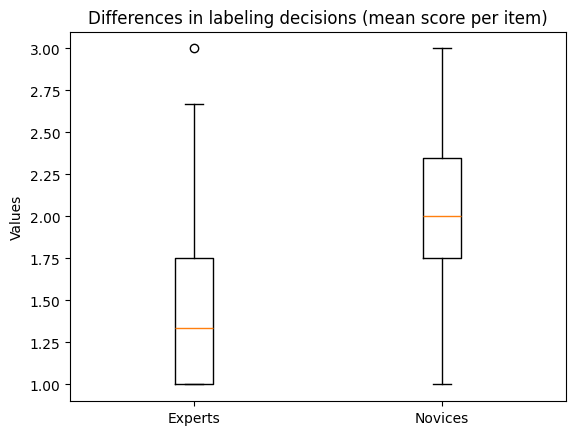

In [12]:
data1 = mean_scores(df_argumentquality_experts, "effectiveness")
data2 = mean_scores(df_argumentquality_novices, "effectiveness")

plt.boxplot([data1, data2], tick_labels=["Experts", "Novices"])
plt.title('Differences in labeling decisions (mean score per item)')
plt.ylabel('Values')
plt.show()

From the boxplot, we see that novice annotators tend to give ratings near the center of the scale, resulting in an approximately normal distribution of their *aggregated* ground truth scores per item (computed by taking the mean across annotators). In contrast, expert annotators are more likely to assign lower ratings, so their label distribution is skewed toward the lower end of the scale.

# How do label distributions differ between groups?
So far, we have investigated the inter-annotator agreement scores for different reference populations: for all annotators, regardless of demographics, as well as separately for female and male annotators. We have also compared these scores across the different groups. **To sum up: we have learnt how we can analyze and interpret agreement within and across groups.**

We now go one step further and ask: can we directly compare how similar or dissimilar annotation decisions in two distinct groups are? The goal is to take into account the full range of *non-aggregated* label decisions, assuming that different groups have unique distributions across labels. **Fully following the descriptive approach of data annotation, we therefore directly compare the label distributions between the two annotator groups.**

*Note: For the following analysis, it is assumed that all label decisions are valid assessments.*

## We employ the Wasserstein distance for this analysis.

The Wasserstein distance allows to compare group-specific labeling patterns while embracing the diversity of label decisions for individual data points. It thereby acts in a *non-aggregated manner*, valuing the diversity of perceptions (remember: we follow the descriptive approach).

**Why use a non-aggregated approach like this?** In the short excursus on "effectiveness" (see above), we have built aggregate labels per data point through the mean of all annotators. For example, experts rated the argument "it is true that bottled water is a waste, but bottles can be reused!" for "effectiveness" with labels 1, 1, and 2, yielding a mean of 1.33. Interpreted, this means that it is not accepted that for some experts the perceived effectiveness is higher than for others. As a result, this approach discards valuable information about existing label variation; it *denies the existence of multiple valid asssessments*. Wasserstein distance retains this information.

For this approach we write two functions. The first function is to extract the annotations per data point, the second calculates the Wasserstein distance between two annotator groups for the each data point in a Dataframe.

In [13]:
def get_annotations(df, dimension, row):
    """
    Extract all label decisions from a row (invidiual data point).

    Args:
        df (pd.Dataframe): Dataframe containing rows of data points with columns of annotations
        dimension (str): Name of the dimensions as contained in the dataframe
        row (int): Row id of the data point

    Returns:
        list: Labels for the data point
    """
    # Get the columns that correspond to the dimension (e.g., columns starting with "clarity")
    cols = [col for col in df.columns if col.startswith(dimension)]
    # Filter those columns that contain annotations (in case of sparse annotation)
    annotations = [df.iloc[row][col] for col in cols if not np.isnan(df.iloc[row][col])]
    return annotations

In [14]:
def calc_Wasserstein_dist(df1, df2, dimensions, id_col, text_col):
    """
    Compute Wasserstein distances between two groups for each data point.
    
    Args:
        df1 (pd.Dataframe): Dataframe with annotations of group 1
        df2 (pd.Dataframe): Dataframe with annotations of group 2
        dimensions (list): Dimensions for which the Wasserstein distances should be computed
        id_col (str): Name of the id column in the passed dataframes
        text_col (str): Name of the text column in the passed dataframes

    Returns:
        pd.Dataframe: Per data point Wasserstein distance scores
    """
    # Init the outcome dataframe with id and text columns
    wasserstein_df = pd.DataFrame({
        "id": df1[id_col], 
        "text": df1[text_col]
        })

    # Iterate over all dimensions to be accounted for
    for dimension in dimensions:
        dimension_results = []

        # Iterate over all data points
        for row in range(len(df1)):
            # Extract the annotations of both groups for the data point
            annotations1 = get_annotations(df1, dimension, row)
            annotations2 = get_annotations(df2, dimension, df2.index[df2[id_col] == df1[id_col][row]][0])

            # Compute Wasserstein distance if both groups annotated
            if not (len(annotations1) == 0 or len(annotations2) == 0):
                dimension_results.append(wasserstein_distance(annotations1, annotations2))
        
        wasserstein_df["Wasserstein distance for "+dimension] = dimension_results
    
    return wasserstein_df

Explained in more detail, what these functions do for each data point is:

1. Extract the annotations from both groups.
2. Transform them into label probability distributions (implemented inside the *wasserstein_distance* function; you don't have to take care of this yourself).
3. Computing the Wasserstein distance (also in the *wasserstein_distance* function call).
4. Storing the result in a Dataframe.

Let's take the first row in the MHS dataset and the dimension of "insult" as an example:

In [15]:
# 1. Extract the annotations from both groups.
ann_female = get_annotations(df_hatespeech_female, "insult", 0)
ann_male = [float(v) for v in get_annotations(df_hatespeech_male, "insult", 0)]

# Note: the list comprehension is just for more accessible formatting but not needed in general
print("female group", [float(v) for v in ann_female])
print("male_group", [float(v) for v in ann_male])

female group [3.0, 3.0, 1.0]
male_group [2.0, 2.0]


We have three labels from the female group (3, 3, 1) and two labels from the male group (2,2).

These label lists are then transformed into probability distributions over the labels:

| labels | 0 | 1 | 2 | 3 | 4 |
| --- | --- | --- | --- | --- | --- |
| female group | 0/3 | 1/3 | 0/3| 2/3 | 0/3 |
| male group | 0/2 | 0/2 | 2/2| 0/2 | 0/2 | 

And then the Wasserstein distance is computed...

In [16]:
float(wasserstein_distance(ann_female, ann_male))  # float() just for formatting, not needed in general

1.0

Reconciling with the idea of earth piles: Imagine you have piles of earth located at label 1 and label 3 (distribution corresponding to female group) and you want to move this earth to fill a hole located at label 2 (distribution corresponding to male group). To do this, you would need to move 1/3 of the earth from label 1 one step to the right, and 2/3 of the earth from label 3 one step to the left. The total amount of earth moved is therefore 1/3 + 2/3 = 1 unit of earth. This is exactly the distance computed.

Now, let's emply Wasserstein distance at scale for both example tasks!

### Hate speech detection (example task 1)

In [17]:
# Running this script takes some time (~15 min)
result_hatespeech = calc_Wasserstein_dist(
    df_hatespeech_female,
    df_hatespeech_male,
    hatespeech_dimensions,
    "comment_id",
    "text"
)

In [19]:
result_hatespeech.iloc[20:23,:]  # iloc is used to select rows and columns by their index numbers

,id,text,Wasserstein distance for respect,Wasserstein distance for insult,Wasserstein distance for humiliate,Wasserstein distance for violence
20,12537,"""Woman are born in the kitchen and are supposed to make me sandwiches. If they dont like that then they are an angry feminist."" - misogynistic, edgy, unoriginal, and unfunny memer",1.0,1.5,1.0,1.5
21,33509,"I remember when you could say Fag or faggot and never did the public ever take it as ""I hate Gay dudes""",0.0,0.0,0.5,1.5
22,542,"I love being a woman, but I wouldn't say there are ""perks"" to being one.",0.5,1.0,1.0,0.0


Overall, we observe that the distance between the label distributions of the two groups varies depending on the specific annotation item.

While examining such details is certainly informative, we need to summarize the individual Wasserstein distance scores to gain more global insights. To achieve this, we calculate descriptive statistics per dimension.

In [20]:
result_hatespeech.iloc[:, 2:].describe()

,Wasserstein distance for respect,Wasserstein distance for insult,Wasserstein distance for humiliate,Wasserstein distance for violence
count,300.000000,300.000000,300.000000,300.000000
mean,0.562778,0.679444,0.724444,0.544444
std,0.500319,0.560302,0.538032,0.567832
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.333333,0.500000,0.000000
50%,0.500000,0.500000,0.500000,0.500000
75%,1.000000,1.000000,1.000000,1.000000
max,3.000000,3.000000,2.500000,2.500000


<div style="border: 2px solid #337eafff; border-radius: 8px; padding: 12px; background-color: #f9fff9;">
<b>Our results tell us:</b>
<ul>
  <li>Considering the mean values, the two annotator groups are most dissimilar in their selection of labels for the dimensions of "humiliate" and "insult" (on a distributional level, using non-aggregated labels as ground truth), while the distributions for "violence" and "respect" are the most alike.</li>
  <li>While the 0%, 50%, and 75% percentiles are the same across dimensions, there are differences at the 25% percentile. This suggests that the collective of individuals in both annotation groups produces more divergent annotation patterns (i.e., label distributions) for "humiliate" and "insult", emphasizing the previous point.</li>
  <li>Overall, the results according to the descriptive paradigm indicate that women and men perceive the constructs "humiliate" and "insult" more distinctly than the other two constructs analyzed.</li>
</ul>
</div>

### Argument quality assessment (example task 2)

In [21]:
result_argumentquality = calc_Wasserstein_dist(
    df_argumentquality_experts,
    df_argumentquality_novices,
    argumentquality_dimensions,
    "#id",
    "argument"
)

In [22]:
result_argumentquality

,id,text,Wasserstein distance for clarity,Wasserstein distance for credibility,Wasserstein distance for effectiveness,Wasserstein distance for emotional_appeal
0,arg219250,"it is true that bottled water is a waste, but bottles can be reused!",0.333333,0.666667,1.000000,1.333333
1,arg219293,Most Americans on average recycle 86-88% of there bottle waters. That is more than half! So stop complaining that we dont recycle because we do! <br/> http://www.treehugger.com/culture/23-percent-of-americans-donatmt-recycle.html,0.500000,1.333333,0.166667,0.666667
2,arg219258,"Banning bottled water would hurt the economy because it would leave hundreds of people without jobs and the big corporations like Dasani and Nestle would loose millions of dollars. It would hurt the economy severely. Millions of Americans use and purchase water bottle everyday so, banning them would only hurt big corporations. <br/> http://www.nestlewaterscorporate.com/bottled_water_things_to_know/",0.666667,0.666667,0.666667,0.666667
3,arg219259,"Bottled water is somewhat less likely to be found in developing countries, where public water is least safe to drink. Many government programs regularly disperse bottled water for various reasons. Distributing small bottles of water is much easier than distributing large bulk storages of water. Also contamination from large water storage containers is much more likely than from single 12-20 ounce bottles of water.",0.250000,0.666667,0.250000,0.416667
4,arg219244,"Western Europe consumes almost 50% of the world's bottled water. Many claim that this is due to European culture, since the continent has had very polluted waters due to agriculture and industry dating back to the Industrial Revolution. The water bottles they buy help us.",0.000000,0.500000,1.000000,0.166667
...,...,...,...,...,...,...
299,arg168830,"Raffles came and left Singapore, returning after a long period of time. Farquar stayed here all the time, and solved many problems. Raffles did not do much at all compared to Farquar.",0.333333,0.333333,1.333333,0.666667
300,arg168774,"Farquhar was the one to implement the actual operations, whereas Raffles only came up with the ideas, which would or would not work. Actions require action, and Farquhar implemented those ideas.",0.250000,0.500000,0.083333,0.500000
301,arg168801,"Farquhar contributed significantly, even forking out his own money to start up the colony carved out of the jungle, by first offering money as an incentive for people to hunt and to exterminate rats and centipedes. Raffles did nothing of that sort.",1.000000,0.666667,0.666667,0.333333
302,arg168822,"Raffles neglected Singapore when he went around conquering other 'more useful' countries for about FOUR years, leaving all the work to Farquhar to settle. Plus, to drive my point further, the countries that were run by Raffles all ended up BADLY. This shows that Raffles was a bad developer of the country.",0.666667,1.000000,1.333333,1.000000


In [23]:
result_argumentquality.iloc[:, 2:].describe()

,Wasserstein distance for clarity,Wasserstein distance for credibility,Wasserstein distance for effectiveness,Wasserstein distance for emotional_appeal
count,304.000000,304.000000,304.000000,304.000000
mean,0.545183,0.572525,0.663181,0.576754
std,0.324043,0.366893,0.403708,0.350232
min,0.000000,0.000000,0.000000,0.000000
25%,0.333333,0.333333,0.333333,0.333333
50%,0.500000,0.516667,0.666667,0.500000
75%,0.666667,0.808333,1.000000,0.750000
max,1.666667,1.666667,1.714286,2.000000


<div style="border: 2px solid #337eafff; border-radius: 8px; padding: 12px; background-color: #f9fff9;">
<b>Our results tell us:</b>
<ul>
  <li>The mean Wasserstein distance is very similar for "clarity", "credibility", and "emotional_appeal", but higher for "effectiveness".</li>
  <li>This difference is especially apparent in the higher percentiles (50% and 75%), indicating greater disparity at the upper end of the distance values.</li>
  <li>Overall, the results according to the descriptive paradigm suggest that experts and novice annotators perceive the "effectiveness" of an argument more distinctly than other quality indicators.</li>
  <li>Additionally, as in example task 1, each dimension has a minimum distance of 0, which suggests that there exist data points that are identically perceived across certain populations.</li>
</ul>
</div>

# Discussion and Takeaways:

In this tutorial, we explored two methods for comparing groups of annotators based on their labeling behavior. We began with the established Krippendorff’s Alpha to measure agreement within selected annotator groups and in the overall population of annotators, analyzing whether differences exist between groups. We then applied the Wasserstein distance as a metric to directly measure the distance between group-specific label distributions, allowing us to compare differences in labeling behavior at a non-aggregated level per annotation unit. 

#### Research question (example task 1)
Is there a difference in annotation behavior for hate speech between women and men annotators? We hypothesize that, as women may more frequently be targeted by hate speech, they may perceive and annotate it differently than men.

**Answer:** The analysis indicates that woman are more consistent in their level of inter-annotator agreement across the indicator dimensions (i.e., respect, insult, humiliate, and violence). While the Krippendorff's Alpha scores are more similar for some indicators (i.e., insult and respect), for others we observe greater label variety, especially within the male annotator group (i.e., humiliate and violence). Examining the label probability distributions directly, we find further evidence of group-specific label patterns.

#### Research question (example task 2)
Is there a difference in label variation between experts, in this case senior researchers that are very familiar with the construct, and novices, in this case undergraduate students that were newly introduced to the construct. We hypothesize that expert annotators label in a more homogeneous way than novices.

**Answer:** Generally, argument quality assessment proves to be very subjective. The novice annotators achieve lower inter-annotator agreement scores in general, presumably due to their lack in expertise. However, for "emotional appeal", both groups agree closely, which may suggest that expertise---at least for this indicator of argument quality---is not crucial. Examining the label probability distributions directly, we find that in particular the assessment of "effectiveness" exhibits more dissimilar label patterns within the distinct groups. One reason may be a more intuitive assessment of novices vs. a more theory-driven assessment by experts.

### Further thoughts
- Following on from the previous paragraph, it becomes clear that it is essential to consider the target application from the outset of data creation. If we aim to implement a system that assesses argument quality in, e.g., social media posts from a theoretical perspective, experts may be the most appropriate choice of annotators. Conversely, if we want to capture lay people's perception of argument quality, novices or crowdworkers may be more suitable.
- To derive meaningful general conclusions from studying annotator groups, it is important to ensure a large enough sample of annotators and a careful selection.
- Annotation errors occur regularly. It is important to understand that---even in the descriptive annotation paradigm---not all variation is due to subjectivity. Distuingishing errors from valid disagreement is an ongoing field of research.
- It is also important to note that you won't always find that groups agree more within themselves than with other groups. For example, you can see this by looking into the "humiliate" dimension. This dimension generates higher agreement between the female and male groups than within the novice group itself.

# References

Artstein, R, & Poesio, M. (2008). Inter-Coder Agreement for Computational Linguistics. *Computational Linguistics* 2008; 34 (4): 555-596. <https://doi.org/10.1162/coli.07-034-R2>

Romberg, J., Maurer, M., Wachsmuth, H., & Lapesa G. (2025). Towards a perspectivist turn in argument quality assessment. *Proceedings of the 2025 Conference of the Nations of the Americas Chapter of the Association for Computational Linguistics: Human Language Technologies (Volume 1: Long Papers)*. <https://arxiv.org/abs/2502.14501>

Röttger, P., Vidgen, B., Hovy, D., & Pierrehumbert, J. (2022). Two contrasting data annotation paradigms for subjective NLP tasks. *Proceedings of the 2022 Conference of the North American Chapter of the Association for Computational Linguistics: Human Language Technologies*. <https://doi.org/10.18653/v1/2022.naacl-main.13>

Wachsmuth, H., Naderi, N., Hou, Y., Bilu, Y., Prabhakaran, V., Thijm, T. A., Hirst, G., & Stein, B. (2017a). Computational argumentation quality assessment in natural language. *Proceedings of the 15th Conference of the European Chapter of the Association for Computational Linguistics: Volume 1, Long Papers*. <https://aclanthology.org/E17-1017/>

# Datasets

Kennedy, C. J., Bacon, G., Sahn, A., & von Vacano, C. (2020). Measuring Hate Speech [Dataset]. Hugging Face. <https://huggingface.co/datasets/ucberkeley-dlab/measuring-hate-speech>

Mirzakhmedova, N., Goshen, Chang, C. H., & Stein, B (2024). Are Large Language Models Reliable Argument Quality Annotators? [Dataset]. Zenodo. <https://zenodo.org/records/13692561>

Wachsmuth, H., Naderi, N., Hou, Y., Bilu, Y., Prabhakaran, V., Thijm, T. A., Hirst, G., & Stein, B. (2017b). Dagstuhl-15512-ArgQuality [Dataset]. Zenodo. <https://doi.org/10.5281/zenodo.3973285>